In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
data = pd.read_csv('../data/titanic_train_temp.csv')
val_data = pd.read_csv('../data/titanic_val_temp.csv')

In [ ]:
data.head()

In [ ]:
class FareTransformer(TransformerMixin):

    def transform(self, fare, **transform_params):
        fare = fare.clip(0, np.percentile(fare, 99))
        return fare.astype('int')

    def fit(self, X, y=None, **fit_params):
        return self


In [5]:
sex_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehotencoder', OneHotEncoder())
])

embarked_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehotencoder', OneHotEncoder())
])

other_transformer = Pipeline([
    ('imputer',SimpleImputer(strategy='median'))
])

age_transformer = Pipeline([
    ('imputer',SimpleImputer(strategy='median'))
    # we can add a custom model transformer later
])

fare_transformer = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('fare_transformer', FareTransformer())
])




In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('sex', sex_transformer, ['Sex']),
        ('age', age_transformer, ['Age']),
        ('embarked', embarked_transformer, ['Embarked']),
        ('other variables', other_transformer, ['Pclass','SibSp','Parch']),
        ('fare', fare_transformer, ['Fare']),
    ])


In [7]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('randomForest', RandomForestClassifier(n_estimators=100))
])

In [8]:
X = data.drop('Survived', axis=1)
y = data['Survived']
model.fit(X,y)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('sex', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value='missing', missing_values=nan,
       strategy='constant'...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [9]:
X_val = val_data.drop('Survived', axis=1)
y_val = val_data['Survived']
y_hat = model.predict_proba(X_val)[:,1]

In [10]:
roc_auc_score(y_val, y_hat)

0.9015026192445549

In [11]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name


In [12]:
feature_importances = model.named_steps['randomForest'].feature_importances_

In [13]:
feat_names = get_column_names_from_ColumnTransformer(model.named_steps['preprocessor'])

In [16]:
feature_series = pd.Series(data=feature_importances, index=feat_names)
feature_series.sort_values(inplace=True)

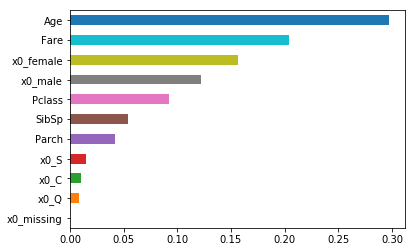

In [17]:
feature_series.plot(kind='barh')